<a href="https://colab.research.google.com/github/zahrazfrh733/Tugas-Pa-anam/blob/main/Tugas_DL_Natural_Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow Version: 2.19.0
Eager execution: True

--- Memuat Gambar Awal ---


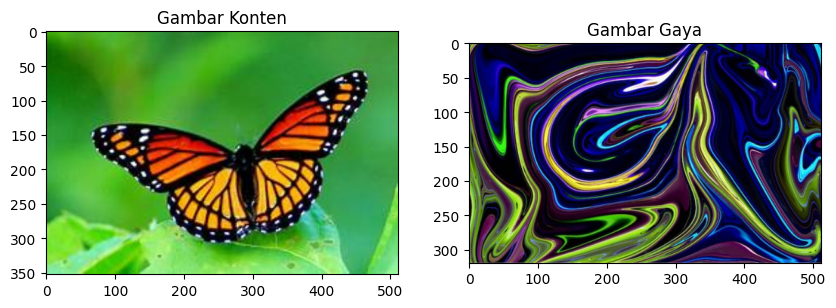


--- Memulai Proses Style Transfer (Optimasi Iteratif) ---
Ini akan memakan waktu beberapa menit. Harap bersabar...
Epoch 1/10 selesai. Progress: 10.00%
Epoch 2/10 selesai. Progress: 20.00%
Epoch 3/10 selesai. Progress: 30.00%
Epoch 4/10 selesai. Progress: 40.00%
Epoch 5/10 selesai. Progress: 50.00%
Epoch 6/10 selesai. Progress: 60.00%
Epoch 7/10 selesai. Progress: 70.00%
Epoch 8/10 selesai. Progress: 80.00%
Epoch 9/10 selesai. Progress: 90.00%
Epoch 10/10 selesai. Progress: 100.00%

✅ Optimasi Selesai dalam 63.58 detik.

--- Hasil Akhir Style Transfer ---


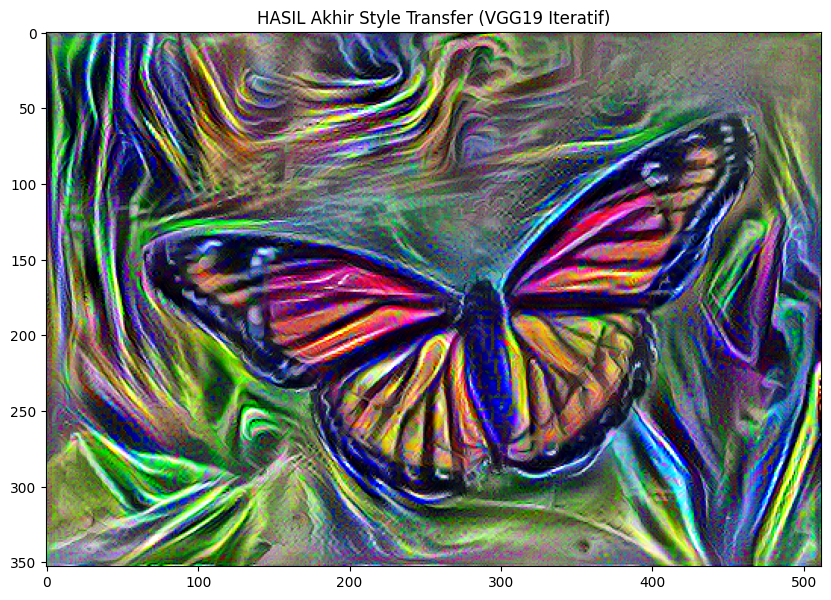


✅ Gambar hasil telah disimpan sebagai 'hasil_model_dua_gambar' di lingkungan Colab.


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import time

# --- 1. Konfigurasi Awal ---
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
print("TensorFlow Version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())

# --- 2. Fungsi Pembantu (Load, Preprocess, Deprocess, Display) ---

def load_img(path_to_img):
    max_dim = 512 # Ukuran gambar akan diskalakan ke sini
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # Tambahkan dimensi batch
    return img

# Fungsi untuk menampilkan gambar
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

# --- 3. Tentukan Gambar Konten dan Gaya ---

content_path = '/content/gambar pertama.jpg'
style_path = '/content/gambar style.jpg'

print("\n--- Memuat Gambar Awal ---")
try:
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    # Visualisasi awal
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(content_image, 'Gambar Konten')
    plt.subplot(1, 2, 2)
    imshow(style_image, 'Gambar Gaya')
    plt.show()

except Exception as e:
    print(f"ERROR saat memuat gambar. Pastikan URL atau path file benar. Detail: {e}")
    exit()

# --- 4. Membangun Model VGG19 untuk Style Transfer ---

# Layers yang akan digunakan untuk menghitung content loss dan style loss
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    """Memuat model VGG19 dan mengekstrak output dari lapisan yang ditentukan."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Model untuk ekstraksi fitur konten
content_model = vgg_layers(content_layers)
# Model untuk ekstraksi fitur gaya
style_model = vgg_layers(style_layers)

# Fungsi untuk menghitung Gram Matrix (digunakan untuk style loss)
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / (num_locations)

# Class StyleContentModel untuk mendapatkan fitur konten dan gaya sekaligus
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # Normalisasi input agar sesuai dengan VGG
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_features = [gram_matrix(style_output)
                          for style_output in style_outputs]

        content_features = [content_output
                            for content_output in content_outputs]

        return {'content': content_features, 'style': style_features}

extractor = StyleContentModel(style_layers, content_layers)

# Ekstrak fitur gaya dan konten dari gambar asli
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Gambar yang akan dioptimasi, dimulai dari gambar konten
image = tf.Variable(content_image)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Bobot untuk content dan style loss
style_weight = 1e-2 # Bobot style loss
content_weight = 1e4 # Bobot content loss

# Fungsi untuk menghitung total loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_output - style_target)**2)
                           for style_output, style_target in zip(style_outputs, style_targets)])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_output - content_target)**2)
                             for content_output, content_target in zip(content_outputs, content_targets)])
    content_loss *= content_weight / num_content_layers

    total_loss = style_loss + content_loss
    return total_loss

# Fungsi untuk clipping nilai piksel agar tetap dalam rentang [0, 1]
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Fungsi langkah training
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image)) # Pastikan piksel tetap di rentang [0,1]

# --- 5. Jalankan Proses Optimasi ---
print("\n--- Memulai Proses Style Transfer (Optimasi Iteratif) ---")
print("Ini akan memakan waktu beberapa menit. Harap bersabar...")

epochs = 10
steps_per_epoch = 100 # Jumlah iterasi per epoch
total_steps = epochs * steps_per_epoch

start_time = time.time()

for i in range(epochs):
    for j in range(steps_per_epoch):
        train_step(image)
    print(f"Epoch {i+1}/{epochs} selesai. Progress: {((i+1)*steps_per_epoch)/total_steps*100:.2f}%")
    # Optional: Visualisasikan hasil setiap beberapa epoch
    # plt.figure(figsize=(6, 6))
    # imshow(image.read_value(), f"Epoch {i+1} Output")
    # plt.show()

end_time = time.time()
print(f"\n✅ Optimasi Selesai dalam {end_time - start_time:.2f} detik.")

# --- 6. Tampilkan dan Simpan Hasil Akhir ---

## TAMPILKAN HASIL
print("\n--- Hasil Akhir Style Transfer ---")
plt.figure(figsize=(10, 10))
imshow(image.read_value(), 'HASIL Akhir Style Transfer (VGG19 Iteratif)')
plt.show()

## SIMPAN HASIL KE FILE
output_image_final = tf.image.convert_image_dtype(image.read_value(), dtype=tf.uint8)
output_image_final = tf.squeeze(output_image_final)

filename = 'hasil_model_dua_gambar'
tf.io.write_file(filename, tf.image.encode_png(output_image_final))

print(f"\n✅ Gambar hasil telah disimpan sebagai '{filename}' di lingkungan Colab.")